In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sunpy.time import parse_time

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *

import os
import shutil
import datetime

from region_detector import *
from resnet_model import *
from lstm_model import *
from utils import *

In [45]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
pd.set_option('display.max_rows', 500)

In [6]:
EVENTS_BY_DATE_DIR = './events_by_date'
AIA_DATA_DIR = '../../MVTS_data_preparation/data'

IMG_SIZE=128

In [7]:
def GetClosestDataFileByDate(dt, rounding):
    AIA_data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    tmp_dt = dt
    minute = 0
    
    if(rounding == "down"):
        minute = GetClosestMultipleDown(tmp_dt.minute, 6)
    elif(rounding == "up"):
        minute = GetClosestMultipleUp(tmp_dt.minute, 6)
    
    if(minute == 60):
        tmp_dt = tmp_dt + datetime.timedelta(hours=1)
        minute = 0
    
    AIA_data_time = f'{tmp_dt.hour:02d}{minute:02d}'
    AIA_data_filename = f'AIA{AIA_data_date}_{AIA_data_time}_0094.npz'
    
    return AIA_data_filename

In [8]:
def build_feature_extractor():
    feature_extractor = CustomResNet50(
        weights=None,
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 1),
    )
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))

    outputs = feature_extractor(inputs)
    
    return Model(inputs, outputs, name="feature_extractor")

In [9]:
def build_resnet_model():
    resnet_model = CustomResNet50(
        weights=None,
        include_top=True,
        input_shape=(IMG_SIZE, IMG_SIZE, 1),
    )
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))
    outputs = resnet_model(inputs)
    model = Model(inputs, outputs, name="resnet_model")
    
    return model

In [10]:
def build_lstm_model():
    resnet_model = CustomResNet50(
        weights=None,
        include_top=True,
        input_shape=(IMG_SIZE, IMG_SIZE, 1),
    )
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))
    outputs = resnet_model(inputs)
    model = Model(inputs, outputs, name="resnet_model")
    
    return model

In [23]:
def PredictFlareStartLocationResnet(im, predictor):
    coord_cutout_dict = GetImageTopNRegionsCoordCutoutDict(im)
    predictions_dict = {}
    for k, v in coord_cutout_dict.items():
        new_im = cv2.resize(v, (128, 128), interpolation = cv2.INTER_AREA)
        new_im = np.array([new_im.reshape(128, 128, 1)])
        predictions_dict[k] = predictor.predict(new_im, verbose=0)
    sorted_prediction_list = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1][0])}
    # sorted_prediction_list = list({k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1][0][1])})
    
    return sorted_prediction_list

In [22]:
def PredictFlareStartLocationLSTM(images, predictor, feature_extractor, lstm_model):
    features = []
    for im in images:
        coord_cutout_dict = GetImageTopNRegionsCoordCutoutDict(im)
        predictions_dict = {}
        for k, v in coord_cutout_dict.items():
            new_im = cv2.resize(v, (128, 128), interpolation = cv2.INTER_AREA)
            new_im = np.array([new_im.reshape(128, 128, 1)])
            predictions_dict[k] = predictor.predict(new_im, verbose=0)
        # sorted_prediction_list = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1][0], reverse=True)}
        # sorted_prediction_list = {k: v for k, v in sorted(predictions_dict.items(), key=lambda item: item[1][0])}
        top_cutout_key = sorted(predictions_dict, key=predictions_dict.get, reverse=True)[0]
        top_cutout = coord_cutout_dict[top_cutout_key]
        top_cutout = cv2.resize(top_cutout, (128, 128), interpolation = cv2.INTER_AREA)
        top_cutout = np.array([top_cutout.reshape(128, 128, 1)])
        plt.imshow(top_cutout[0])
        plt.show()
        features.append(feature_extractor.predict(np.array(top_cutout), verbose=0))
    
    features = np.array([np.array(features).reshape(6, 2048)])
    preds = lstm_model.predict(features, verbose=0)
    return preds

In [13]:
def GetPositiveLabelFilepathsForYearMonth(year, month):
    positive_label_filenames = set()
    positive_label_filepaths = set()
    month_folder_csv = f'{EVENTS_BY_DATE_DIR}/{year:04}/{month}.csv'
    month_folder_path = f'{AIA_DATA_DIR}/{year:04}/{month:02}'
    if not os.path.exists(month_folder_csv):
        print(f'no such file: {month_folder_csv}')
        return
    month_df = pd.read_csv(month_folder_csv)
    
    for index, row in month_df.iterrows():
        event_dt = parse_time(row['event_starttime'], precision=0).datetime
        AIA_filename = GetClosestDataFileByDate(event_dt, 'down').rsplit('.', 1)[0]
        positive_label_filenames.add(AIA_filename)
    
    for subdir, dirs, files in os.walk(month_folder_path):
        for file in files:
            clean_filename = file.rsplit('.', 1)[0]
            if clean_filename in positive_label_filenames:
                positive_label_filepaths.add(os.path.join(subdir, file))
                
    return positive_label_filepaths

In [28]:
def RunExperiment(year, month, predict_function):
    dt = datetime.datetime(year, month, 7)
    filepaths = []
    for subdir, dirs, files in os.walk(f'../../MVTS_data_preparation/data/{year:04}/{month:02}'):
        for file in files:
            filepaths.append(os.path.join(subdir, file))
    filepaths = sorted(filepaths)
    
    for filepath in filepaths:
        im = np.load(filepath)['x']
        prediction_list = PredictFlareStartLocationResnet(im, predict_function)
        print(filepath.rsplit('/', 1)[1].rsplit('.', 1)[0])
        print(prediction_list)

In [26]:
resnet_model = build_resnet_model()
resnet_model.load_weights('./resnet50_weights/checkpoints/resnet_checkpoints/sgd_checkpoint')

channels_last


In [35]:
# RunExperiment(2016, 1, resnet_model)

In [23]:
plf = GetPositiveLabelFilepathsForYearMonth(2016, 1)

In [24]:
plf

{'../../MVTS_data_preparation/data/2016/01/01/AIA20160101_0630_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/01/AIA20160101_0936_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/03/AIA20160103_2018_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/07/AIA20160107_1236_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/08/AIA20160108_1118_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/12/AIA20160112_1336_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/14/AIA20160114_1000_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/15/AIA20160115_1518_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_0730_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_0906_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_1112_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_1424_0094.npz',
 '../../MVTS_data_preparation/data/2016/01/20/AIA20160120_1700_0094.npz',
 '../../MVTS_data_preparation/data/201

In [9]:
feature_extractor = build_feature_extractor()
feature_extractor.load_weights('./checkpoints/resnet_checkpoints/my_checkpoint')
lstm_model = get_sequence_model()
lstm_model.load_weights('./checkpoints/lstm_checkpoints/my_checkpoint')

channels_last


In [97]:
dt = datetime.datetime(2016, 1, 7)
filepaths = []
for subdir, dirs, files in os.walk(f'../../MVTS_data_preparation/data/{dt.year}/{dt.month:02}/{dt.day:02}'):
    for file in files:
        filepaths.append(os.path.join(subdir, file))
filepaths = sorted(filepaths)

In [98]:
filepaths = filepaths[120:]

In [11]:
for file in filepaths:
    data = np.load(file)['x']
    print(file.rsplit('/', 1)[1].rsplit('.', 1)[0])
    PredictFlareStartLocation(data, resnet_model)
    print('-----------------------------------------------------------------------------------')

AIA20160101_0000_0094


2022-07-24 23:54:58.902164: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-24 23:54:59.513596: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-24 23:54:59.517731: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


{(300, 56): array([[0.6072767]], dtype=float32), (220, 56): array([[0.64755785]], dtype=float32), (184, 428): array([[0.6926701]], dtype=float32)}
-----------------------------------------------------------------------------------
AIA20160101_0006_0094
{(300, 56): array([[0.6057599]], dtype=float32), (220, 56): array([[0.6482343]], dtype=float32), (196, 424): array([[0.68818605]], dtype=float32)}
-----------------------------------------------------------------------------------
AIA20160101_0012_0094


KeyboardInterrupt: 

In [1]:
# for i in range(6, len(filepaths)):
#     past_paths = filepaths[i-6:i]
#     print(filepaths[i].rsplit('/', 1)[1].rsplit('.', 1)[0])
#     past_data = np.array([np.load(x)['x'] for x in past_paths])
#     PredictFlareStartLocationLSTM(past_data, resnet_model, feature_extractor, lstm_model)
#     print('-----------------------------------------------------------------------------------')

In [46]:
t = np.load('../../MVTS_data_preparation/data/2016/10/14/AIA20161014_0730_0094.npz')['x']
coord_cutout_dict = GetImageTopNRegionsCoordCutoutDict(t)
# cutouts = [cv2.resize(x, (128, 128), interpolation = cv2.INTER_AREA) for x in cutouts]
# cutouts = np.array([x.reshape(128, 128, 1) for x in cutouts])

In [47]:
PredictFlareStartLocation(t, resnet_model)

1/1 [==============================] - 0s 33ms/step


{(312, 452): array([[0.5651931 , 0.43480688]], dtype=float32),
 (184, 432): array([[0.5637392, 0.4362608]], dtype=float32),
 (260, 112): array([[0.542031  , 0.45796898]], dtype=float32)}

In [6]:
resnet_model = build_resnet_model()
resnet_model.load_weights('./checkpoints/my_checkpoint')

channels_last


2022-07-24 00:00:00.456737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-24 00:00:01.063273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6656 MB memory:  -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:82:00.0, compute capability: 7.5


In [72]:
coord = ConvertHPCToPixXY((-605.9, -10))
coord = ResizeCoord(coord)

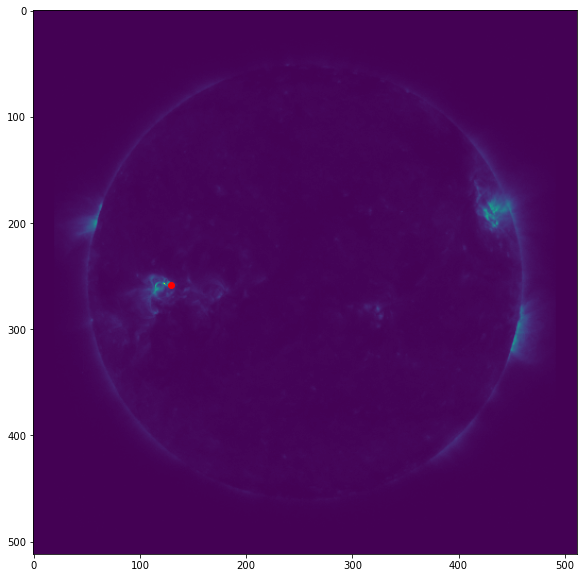

In [73]:
plt.figure(figsize=(10, 10))
plt.imshow(t)
plt.scatter(coord[0], coord[1],color='r')

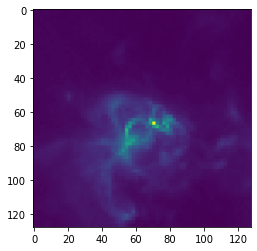

In [76]:
plt.imshow(cutouts[1])

In [42]:
from sunpy.net import attrs as a
from sunpy.net import Fido
tstart = '2016/01/01 00:00:00'
tend = '2016/01/02 00:30:00'
event_type = 'FL'
result = Fido.search(a.Time(tstart,tend), a.hek.EventType(event_type))

In [55]:
type(result['hek'])

sunpy.net.hek.hek.HEKTable

In [61]:
event_table = result['hek']["event_starttime", "event_peaktime", "event_endtime", "fl_goescls", "ar_noaanum", "event_c2error"]
event_df = event_table.to_pandas().rename(columns={
    'event_starttime': 'start_time',
    'event_peaktime': 'peak_time',
    'event_endtime': 'end_time',
    'fl_goescls': 'goes_class',
    #'hgc_coord': 'goes_location',
    'ar_noaanum': 'noaa_active_region',
})

In [62]:
event_df

,start_time,peak_time,end_time,goes_class,noaa_active_region,event_c2error
0,2016-01-01 00:57:57,2016-01-01 00:59:33,2016-01-01 01:05:09,,None,2.000000
1,2016-01-01 02:08:33,2016-01-01 02:09:21,2016-01-01 02:11:33,,None,2.000000
2,2016-01-01 02:47:21,2016-01-01 03:01:33,2016-01-01 03:07:45,,None,2.000000
3,2016-01-01 02:47:23,2016-01-01 02:54:23,2016-01-01 03:00:47,,None,2.000000
4,2016-01-01 02:47:24,2016-01-01 02:53:48,2016-01-01 02:59:24,,None,2.000000
5,2016-01-01 04:38:00,2016-01-01 04:41:00,2016-01-01 04:51:00,B6.2,2473,0.000000
6,2016-01-01 04:38:00,2016-01-01 04:41:00,2016-01-01 04:51:00,B6.2,12477,90.000000
7,2016-01-01 04:39:09,2016-01-01 04:41:21,2016-01-01 04:47:21,,None,2.000000
8,2016-01-01 05:40:33,2016-01-01 05:50:21,2016-01-01 05:56:57,,None,2.000000
9,2016-01-01 05:41:59,2016-01-01 05:44:59,2016-01-01 05:46:23,,None,2.000000
